# Modify aviation emissions
We use data from https://www.flightradar24.com/data/statistics to modify all NOx emissions. For the time period after this, the reduction factor reverts smoothly to 2/3rds the average for the last month we have data for, for the remainder of the 2 years, then returns to baseline. To represent this properly, additional years will be interpolated onto the data. 

Note that flightradar24 no longer reports the first few days of 2020 for free, so we update the data by adding rows rather than replacing the file. 

The consortium has so far agreed that only the NOx emissions from aircraft are important enough to model in this detail. If other emissions are desired, it would be necessary to change the variables `nox_input` and `key_variable` to the appropriate values for the new variable, after which the code could be run. 

In [1]:
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib
import netCDF4 as nc
import numpy as np
import pandas as pd


import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time, cleanup_files

# Running options
Here are the options for loading files and hopefully the only things that will need to be changed to run the code on different data. Assuming the data is updated monthly, the first two options will need updating every time. Other options will only need updating if you want to do a different calculation. 

In [2]:
# String appended on the end of all files. Update with every successful run where the data will be used
# (both with data change and with protocol change). 
version_str = "4year_v5.nc"  # CHANGE ON UPDATE

# which month's data should we use to base the "long tail" of the reversion to baseline? As a 2-digit string.
# Update if we have enough data to use a later month as the baseline. 
month_plat = "12"  # CHANGE ON UPDATE

# variables for loading files
input_folder = "../input/"
output_folder = "../output/aviation/v5/"
nox_input = "NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_flights = "total-number-of-flights_2020.csv"


scenario_string = "_flightrd_mp{}".format(month_plat)

def convert_years_to_days(year):  # Data is recorded in 365-day years
    return (year - 2015) * 365

# We don't want data after 2025. These are overwritten if we want daily results
tcutoff = convert_years_to_days(2050.99)
# Later we may cut off more data
tcutoff_2 = convert_years_to_days(2050.99)
tstart = convert_years_to_days(2015)
# name of the variable in the file
key_variable = "NOx_em_AIR_anthro"
# Years to interpolate, as number of years after 2015. 
yeardif_to_interpolate = [2019, 2021, 2022, 2023, 2024]  
working_string = "_workings"
years_to_mod = [2021, 2022, 2023]
use_daily_data = False
if use_daily_data:
    tcutoff = convert_years_to_days(2030.99)
    tcutoff_2 = convert_years_to_days(2021) + 1
    tstart = convert_years_to_days(2020)

Only change lines below here if you know what you're doing. 
# Calculations begin

In [3]:
flights_change = pd.read_csv(input_folder + input_flights)
flights_change.head(20)

,DateTime,2021 7-day moving average,2021 Number of flights,2020 7-day moving average,2020 Number of flights,2019 7-day moving average,2019 Number of flights
0,01/01/2021,127803.0,93897.0,164362,144067,149020,128717
1,02/01/2021,126909.0,120291.0,165769,175861,150190,162303
2,03/01/2021,125859.0,130037.0,165403,175444,150656,169310
3,04/01/2021,126436.0,137935.0,164985,165733,152503,173386
4,05/01/2021,125693.0,138303.0,166528,172605,153786,161288
5,06/01/2021,125084.0,138576.0,168421,184566,154813,156172
6,07/01/2021,NaN,NaN,171657,183328,159253,163601
7,08/01/2021,NaN,NaN,176691,179306,164227,163535
8,09/01/2021,NaN,NaN,178076,185552,164910,167080
9,10/01/2021,NaN,NaN,179282,183890,165342,172335


# Complementing the flight data
We will use a linear trend to continue the flight data until we reach a level of 2/3rds the average of the last month. 

In [4]:
flights_change["month"] = [int(date[3:5]) for date in flights_change.DateTime]

In [5]:
if use_daily_data:
    # We have to insert a leap-day equivalent into the data
    daily_flight_chng = flights_change.shift(1).append(flights_change.iloc[-1])
    leapday_ind = 30+29
    for ind in range(leapday_ind):
        daily_flight_chng.loc[ind] = daily_flight_chng.loc[ind+1]
    daily_flight_chng["ratio"] = flights_change["2020 7-day moving average"]/flights_change["2019 7-day moving average"]
    daily_flight_chng.index = range(366)
    print(daily_flight_chng)
else:
    monthly_flight_chng = flights_change.groupby("month").mean()
    monthly_flight_chng["ratio"] = monthly_flight_chng["2020 Number of flights"]/monthly_flight_chng["2019 Number of flights"]
    monthly_flight_chng

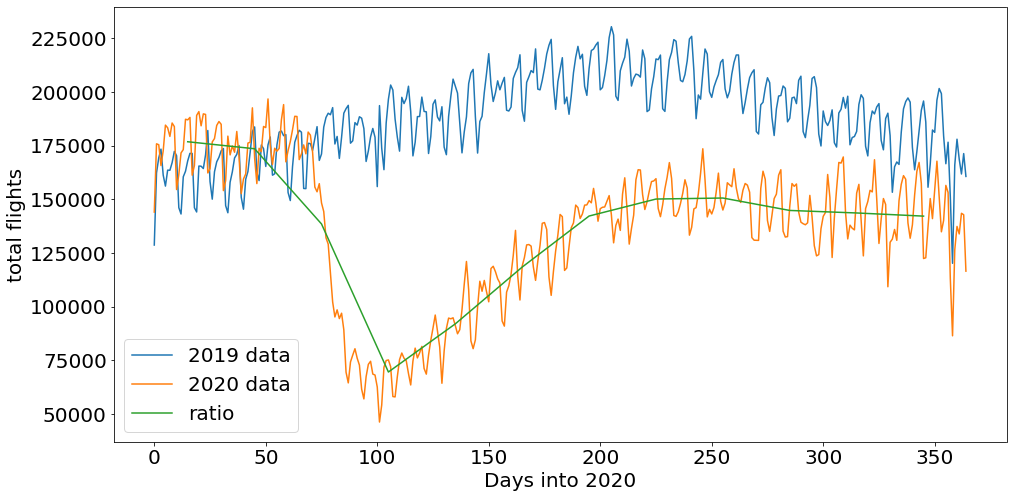

In [6]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
plt.figure(figsize=(16, 8))
plt.plot(range(len(flights_change["2019 Number of flights"])), flights_change["2019 Number of flights"])
plt.plot(range(len(flights_change["2020 Number of flights"])), flights_change["2020 Number of flights"])
if use_daily_data:
    plt.plot(daily_flight_chng.index+1, daily_flight_chng["ratio"]*daily_flight_chng["2019 Number of flights"])
else:
    plt.plot(15+30*(monthly_flight_chng.index-1), monthly_flight_chng["ratio"]*monthly_flight_chng["2019 Number of flights"])
plt.xlabel("Days into 2020")
plt.ylabel("total flights")
plt.legend(["2019 data", "2020 data", "ratio"])

## Add interpolated years
To ensure that 2020 is anomalous, we will interpolate the expected values from 2019, 2021, 2022 and 2023 before modifying 2020. 

In [7]:
# Since the data is extensive, we will cut it up first
start = datetime.now()
data = cutoff_netcdf_time(input_folder, output_folder, nox_input, tcutoff, scenario_string="", compress=False)
end = datetime.now()
print(end - start)

0:00:10.773479


In [8]:
# However some of this change was already included in the model, so we remove the expected rise from 2019 to 2020 
# from this change factor
sum2020 = data.variables[key_variable][12, ...].mean()
sum2015 = data.variables[key_variable][0, ...].mean()
correct_ratio_by = (sum2020/sum2015) ** 0.2
print(correct_ratio_by)

1.0355956322515962


In [9]:
if use_daily_data:
    daily_flight_chng["ratio"] = daily_flight_chng["ratio"] / correct_ratio_by
    daily_flight_chng["ratio"]
else:
    monthly_flight_chng["ratio"] = monthly_flight_chng["ratio"] / correct_ratio_by
    monthly_flight_chng["ratio"]

In [10]:
start = datetime.now()
if use_daily_data:
    for day in range(366):
        if not (365*5+day in data.variables["time"]):
            insert_interpolated_point(data, 5 * 365 + day, 1, 1)
            end = datetime.now()
            print(end - start)
            print("Inserted data for {}".format(day))
else:
    for year in yeardif_to_interpolate:
        yeardif = year - 2015
        for i in range(1,13):
            insert_interpolated_point(data, yeardif * 365 + data.variables["time"][(i - 1)], 12, i)
        end = datetime.now()
        print(end - start)
        print("Inserted data for {}".format(yeardif))

0:01:06.237132
Inserted data for 4
0:01:58.936849
Inserted data for 6
0:02:52.419079
Inserted data for 7
0:03:42.483646
Inserted data for 8
0:04:28.813668
Inserted data for 9


# Perform the emissions modifications
We reduce the emissions in 2020 by a continuously changing amount, and the emissions in 2021 by a constant amount. First we copy and compress the interpolated data, then we modify it as a separate file. 

In [11]:
data.close()
data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, "_baseline" + version_str, compress=True
)
data.close()

In [12]:
data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, working_string, compress=False
)
output = data.variables[key_variable][:]
if use_daily_data:
    for time in range(366):
        timeind = np.where(
            convert_years_to_days(2020) + time == data.variables["time"][:]
        )
        if (len(timeind) != 1):
            print("error in calculating appropriate time")
            stop
        output[timeind, ...] *= daily_flight_chng["ratio"].loc[time]
else:
    for time in range(1, 13):
        timeind = np.where(
            abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12)) == min(
                abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12))
            )
        )
        if (len(timeind) != 1):
            print("error in calculating appropriate time")
            stop
        output[timeind, ...] *= monthly_flight_chng["ratio"].loc[time]
        for year in years_to_mod:
            timeind = np.where(
                abs(data.variables["time"][:] - convert_years_to_days(year + (time - 0.5)/12)) == min(
                    abs(data.variables["time"][:] - convert_years_to_days(year + (time - 0.5)/12))
                )
            )    
            output[timeind, ...] *= monthly_flight_chng["ratio"].iloc[-1]

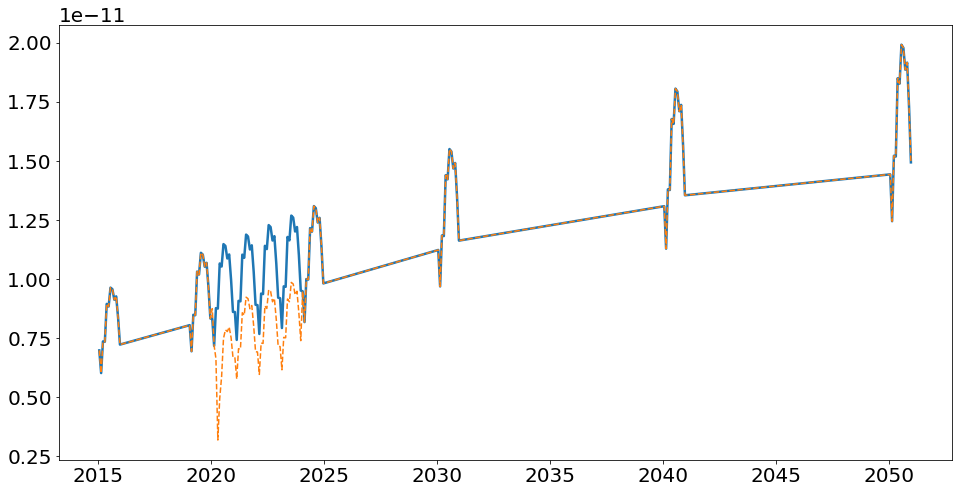

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, data.variables["NOx_em_AIR_anthro"][:, 0, 283, 360], linewidth=2.5)
plt.plot(data.variables["time"][:] / 365 + 2015, output[:, 0, 283, 360],  linestyle="--")

In [14]:
data.variables[key_variable][...] = output[...]
data.close()
# We also want to compress the data again
data = copy_netcdf_file(
    "cut_" + nox_input + working_string, output_folder, output_folder, 
    scenario_string + version_str, compress=True, remove_string=working_string
)

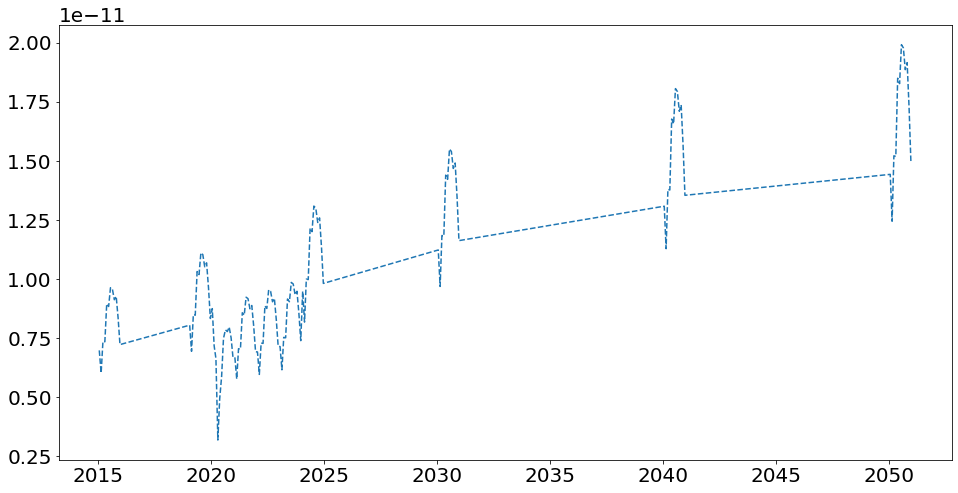

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, output[:, 0, 283, 360],  linestyle="--")

In [16]:
data.close()

In [17]:
# This function will delete the files we don't want
cleanup_files(output_folder, working_string, scenario_string)

Deleting files ['cut_NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc_workings']
